#YOLOv2 Protist Image Classifier Neural Network

##Start

**Environment Setup**

Download and extract the dataset, install dependencies,  setup the neural network, and then train it.

In [1]:
!wget https://www.dropbox.com/s/3qm7xi12bbxgje7/dataset.tar.bz2?dl=0
!tar -jxf dataset.tar.bz2?dl=0
!rm dataset.tar.bz2?dl=0
!pip3 install imgaug

#!/usr/bin/python3

'''
MIT License

Copyright (c) 2017 Ngoc Anh Huynh

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.

This script is modified from: https://github.com/experiencor/keras-yolo2
'''

import os
import sys
import cv2
import copy
import numpy as np
import imgaug as ia
import tensorflow as tf
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
from imgaug import augmenters as iaa
from keras.models import Model
from keras.utils import Sequence
from keras.layers.merge import concatenate
from keras.optimizers import SGD, Adam, RMSprop
from keras.layers.advanced_activations import LeakyReLU
from keras.layers import BatchNormalization, Flatten, Dense, Lambda
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from keras.layers import Reshape, Activation, Conv2D, Input, MaxPooling2D

config = {"model":{
			"labels":               ["Cell"],
			"input_size":           416,
			"anchors":              [0.57273, 0.677385, 1.87446,
									2.06253, 3.33843, 5.47434,
									7.88282, 3.52778, 9.77052,
									9.16828],
			"max_box_per_image":    10,},
		"train":{
			"train_image_folder":   "./dataset/Images/",
			"train_annot_folder":   "./dataset/Annotations/",
			"saved_weights_name":   "./cell.h5",
			"train_times":          8,
			"batch_size":           16,
			"learning_rate":        1e-4,
			"nb_epochs":            1000,
			"warmup_epochs":        0,
			"object_scale":         5.0 ,
			"no_object_scale":      1.0,
			"coord_scale":          1.0,
			"class_scale":          1.0,
			"debug":                True},
		"valid":{
			"valid_image_folder":   "",
			"valid_annot_folder":   "",
			"valid_times":          1}}

class BaseFeatureExtractor(object):
	def __init__(self, input_size):
		raise NotImplementedError("error message")
	def normalize(self, image):
		raise NotImplementedError("error message")
	def get_output_shape(self):
		return self.feature_extractor.get_output_shape_at(-1)[1:3]
	def extract(self, input_image):
		return self.feature_extractor(input_image)

class FullYoloFeature(BaseFeatureExtractor):
	def __init__(self, input_size):
		input_image = Input(shape=(input_size, input_size, 3))
		def space_to_depth_x2(x):
			return tf.space_to_depth(x, block_size=2)
		x = Conv2D(32, (3,3), strides=(1,1), padding='same', name='conv_1', use_bias=False)(input_image)
		x = BatchNormalization(name='norm_1')(x)
		x = LeakyReLU(alpha=0.1)(x)
		x = MaxPooling2D(pool_size=(2, 2))(x)
		x = Conv2D(64, (3,3), strides=(1,1), padding='same', name='conv_2', use_bias=False)(x)
		x = BatchNormalization(name='norm_2')(x)
		x = LeakyReLU(alpha=0.1)(x)
		x = MaxPooling2D(pool_size=(2, 2))(x)
		x = Conv2D(128, (3,3), strides=(1,1), padding='same', name='conv_3', use_bias=False)(x)
		x = BatchNormalization(name='norm_3')(x)
		x = LeakyReLU(alpha=0.1)(x)
		x = Conv2D(64, (1,1), strides=(1,1), padding='same', name='conv_4', use_bias=False)(x)
		x = BatchNormalization(name='norm_4')(x)
		x = LeakyReLU(alpha=0.1)(x)
		x = Conv2D(128, (3,3), strides=(1,1), padding='same', name='conv_5', use_bias=False)(x)
		x = BatchNormalization(name='norm_5')(x)
		x = LeakyReLU(alpha=0.1)(x)
		x = MaxPooling2D(pool_size=(2, 2))(x)
		x = Conv2D(256, (3,3), strides=(1,1), padding='same', name='conv_6', use_bias=False)(x)
		x = BatchNormalization(name='norm_6')(x)
		x = LeakyReLU(alpha=0.1)(x)
		x = Conv2D(128, (1,1), strides=(1,1), padding='same', name='conv_7', use_bias=False)(x)
		x = BatchNormalization(name='norm_7')(x)
		x = LeakyReLU(alpha=0.1)(x)
		x = Conv2D(256, (3,3), strides=(1,1), padding='same', name='conv_8', use_bias=False)(x)
		x = BatchNormalization(name='norm_8')(x)
		x = LeakyReLU(alpha=0.1)(x)
		x = MaxPooling2D(pool_size=(2, 2))(x)
		x = Conv2D(512, (3,3), strides=(1,1), padding='same', name='conv_9', use_bias=False)(x)
		x = BatchNormalization(name='norm_9')(x)
		x = LeakyReLU(alpha=0.1)(x)
		x = Conv2D(256, (1,1), strides=(1,1), padding='same', name='conv_10', use_bias=False)(x)
		x = BatchNormalization(name='norm_10')(x)
		x = LeakyReLU(alpha=0.1)(x)
		x = Conv2D(512, (3,3), strides=(1,1), padding='same', name='conv_11', use_bias=False)(x)
		x = BatchNormalization(name='norm_11')(x)
		x = LeakyReLU(alpha=0.1)(x)
		x = Conv2D(256, (1,1), strides=(1,1), padding='same', name='conv_12', use_bias=False)(x)
		x = BatchNormalization(name='norm_12')(x)
		x = LeakyReLU(alpha=0.1)(x)
		x = Conv2D(512, (3,3), strides=(1,1), padding='same', name='conv_13', use_bias=False)(x)
		x = BatchNormalization(name='norm_13')(x)
		x = LeakyReLU(alpha=0.1)(x)
		skip_connection = x
		x = MaxPooling2D(pool_size=(2, 2))(x)
		x = Conv2D(1024, (3,3), strides=(1,1), padding='same', name='conv_14', use_bias=False)(x)
		x = BatchNormalization(name='norm_14')(x)
		x = LeakyReLU(alpha=0.1)(x)
		x = Conv2D(512, (1,1), strides=(1,1), padding='same', name='conv_15', use_bias=False)(x)
		x = BatchNormalization(name='norm_15')(x)
		x = LeakyReLU(alpha=0.1)(x)
		x = Conv2D(1024, (3,3), strides=(1,1), padding='same', name='conv_16', use_bias=False)(x)
		x = BatchNormalization(name='norm_16')(x)
		x = LeakyReLU(alpha=0.1)(x)
		x = Conv2D(512, (1,1), strides=(1,1), padding='same', name='conv_17', use_bias=False)(x)
		x = BatchNormalization(name='norm_17')(x)
		x = LeakyReLU(alpha=0.1)(x)
		x = Conv2D(1024, (3,3), strides=(1,1), padding='same', name='conv_18', use_bias=False)(x)
		x = BatchNormalization(name='norm_18')(x)
		x = LeakyReLU(alpha=0.1)(x)
		x = Conv2D(1024, (3,3), strides=(1,1), padding='same', name='conv_19', use_bias=False)(x)
		x = BatchNormalization(name='norm_19')(x)
		x = LeakyReLU(alpha=0.1)(x)
		x = Conv2D(1024, (3,3), strides=(1,1), padding='same', name='conv_20', use_bias=False)(x)
		x = BatchNormalization(name='norm_20')(x)
		x = LeakyReLU(alpha=0.1)(x)
		skip_connection = Conv2D(64, (1,1),
								strides=(1,1),
								padding='same',
								name='conv_21',
								use_bias=False)(skip_connection)
		skip_connection = BatchNormalization(name='norm_21')(skip_connection)
		skip_connection = LeakyReLU(alpha=0.1)(skip_connection)
		skip_connection = Lambda(space_to_depth_x2)(skip_connection)
		x = concatenate([skip_connection, x])
		x = Conv2D(1024, (3,3), strides=(1,1), padding='same', name='conv_22', use_bias=False)(x)
		x = BatchNormalization(name='norm_22')(x)
		x = LeakyReLU(alpha=0.1)(x)
		self.feature_extractor = Model(input_image, x)
	def normalize(self, image):
		return image / 255.

def parse_annotation(ann_dir, img_dir, labels=[]):
	all_imgs = []
	seen_labels = {}
	for ann in sorted(os.listdir(ann_dir)):
		img = {'object':[]}
		tree = ET.parse(ann_dir + ann)
		for elem in tree.iter():
			if 'filename' in elem.tag:
				img['filename'] = img_dir + elem.text
			if 'width' in elem.tag:
				img['width'] = int(elem.text)
			if 'height' in elem.tag:
				img['height'] = int(elem.text)
			if 'object' in elem.tag or 'part' in elem.tag:
				obj = {}
				for attr in list(elem):
					if 'name' in attr.tag:
						obj['name'] = attr.text
						if obj['name'] in seen_labels:
							seen_labels[obj['name']] += 1
						else:
							seen_labels[obj['name']] = 1
						if len(labels) > 0 and obj['name'] not in labels:
							break
						else:
							img['object'] += [obj]
					if 'bndbox' in attr.tag:
						for dim in list(attr):
							if 'xmin' in dim.tag:
								obj['xmin'] = int(round(float(dim.text)))
							if 'ymin' in dim.tag:
								obj['ymin'] = int(round(float(dim.text)))
							if 'xmax' in dim.tag:
								obj['xmax'] = int(round(float(dim.text)))
							if 'ymax' in dim.tag:
								obj['ymax'] = int(round(float(dim.text)))
		if len(img['object']) > 0:
			all_imgs += [img]
	return all_imgs, seen_labels

class BatchGenerator(Sequence):
	def __init__(self, images, config, shuffle=True, jitter=True, norm=None):
		self.generator = None
		self.images = images
		self.config = config
		self.shuffle = shuffle
		self.jitter = jitter
		self.norm = norm
		self.anchors = [BoundBox(0, 0, config['ANCHORS'][2*i],
									config['ANCHORS'][2*i+1])\
						for i in range(int(len(config['ANCHORS'])//2))]
		sometimes = lambda aug: iaa.Sometimes(0.5, aug)
		self.aug_pipe = iaa.Sequential([sometimes(iaa.Affine()),
				iaa.SomeOf((0, 5),
						[iaa.OneOf([iaa.GaussianBlur((0, 3.0)),
						iaa.AverageBlur(k=(2, 7)),
						iaa.MedianBlur(k=(3, 11)),]),
						iaa.Sharpen(alpha=(0, 1.0), lightness=(0.75, 1.5)),
						iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255),
													per_channel=0.5),
						iaa.OneOf([iaa.Dropout((0.01, 0.1), per_channel=0.5),]),
						iaa.Add((-10, 10), per_channel=0.5),
						iaa.Multiply((0.5, 1.5), per_channel=0.5),
						iaa.ContrastNormalization((0.5, 2.0),
													per_channel=0.5),],
													random_order=True)],
													random_order=True)
		if shuffle: np.random.shuffle(self.images)
	def __len__(self):
		return int(np.ceil(float(len(self.images))/self.config['BATCH_SIZE']))
	def num_classes(self):
		return len(self.config['LABELS'])
	def size(self):
		return len(self.images)
	def load_annotation(self, i):
		annots = []
		for obj in self.images[i]['object']:
			annot = [obj['xmin'], obj['ymin'], obj['xmax'], obj['ymax'],
					self.config['LABELS'].index(obj['name'])]
			annots += [annot]
		if len(annots) == 0: annots = [[]]
		return np.array(annots)
	def load_image(self, i):
		return cv2.imread(self.images[i]['filename'])
	def __getitem__(self, idx):
		l_bound = idx*self.config['BATCH_SIZE']
		r_bound = (idx+1)*self.config['BATCH_SIZE']
		if r_bound > len(self.images):
			r_bound = len(self.images)
			l_bound = r_bound - self.config['BATCH_SIZE']
		instance_count = 0
		x_batch = np.zeros((r_bound - l_bound, self.config['IMAGE_H'],
							self.config['IMAGE_W'], 3))
		b_batch = np.zeros((r_bound - l_bound, 1, 1, 1,
							self.config['TRUE_BOX_BUFFER'], 4))
		y_batch = np.zeros((r_bound - l_bound, self.config['GRID_H'],
							self.config['GRID_W'], self.config['BOX'],
							4+1+len(self.config['LABELS'])))
		for train_instance in self.images[l_bound:r_bound]:
			img, all_objs = self.aug_image(train_instance, jitter=self.jitter)
			true_box_index = 0
			for obj in all_objs:
				if obj['xmax'] > obj['xmin'] and obj['ymax'] > obj['ymin']\
									and obj['name'] in self.config['LABELS']:
					center_x = .5*(obj['xmin'] + obj['xmax'])
					center_x = center_x / (float(self.config['IMAGE_W']) /\
												self.config['GRID_W'])
					center_y = .5*(obj['ymin'] + obj['ymax'])
					center_y = center_y / (float(self.config['IMAGE_H']) /\
												self.config['GRID_H'])
					grid_x = int(np.floor(center_x))
					grid_y = int(np.floor(center_y))
					if grid_x < self.config['GRID_W'] and\
												grid_y < self.config['GRID_H']:
						obj_indx = self.config['LABELS'].index(obj['name'])
						center_w = (obj['xmax'] - obj['xmin']) /\
						(float(self.config['IMAGE_W']) / self.config['GRID_W'])
						center_h = (obj['ymax'] - obj['ymin']) /\
						(float(self.config['IMAGE_H']) / self.config['GRID_H'])
						box = [center_x, center_y, center_w, center_h]
						best_anchor = -1
						max_iou = -1
						shifted_box = BoundBox(0, 0, center_w, center_h)
						for i in range(len(self.anchors)):
							anchor = self.anchors[i]
							iou = bbox_iou(shifted_box, anchor)
							if max_iou < iou:
								best_anchor = i
								max_iou = iou
						y_batch[instance_count,
								grid_y, grid_x, best_anchor, 0:4] = box
						y_batch[instance_count,
								grid_y, grid_x, best_anchor, 4	] = 1.
						y_batch[instance_count,
								grid_y, grid_x, best_anchor, 5+obj_indx] = 1
						b_batch[instance_count, 0, 0, 0, true_box_index] = box
						true_box_index += 1
						true_box_index = true_box_index %\
												self.config['TRUE_BOX_BUFFER']
			if self.norm != None:
				x_batch[instance_count] = self.norm(img)
			else:
				for obj in all_objs:
					if obj['xmax'] > obj['xmin'] and obj['ymax'] > obj['ymin']:
						cv2.rectangle(img[:,:,::-1], (obj['xmin'],obj['ymin']),
									(obj['xmax'],obj['ymax']), (255,0,0), 3)
						cv2.putText(img[:,:,::-1], obj['name'], (obj['xmin']+2,
									obj['ymin']+12), 0, 1.2e-3 * img.shape[0],
									(0,255,0), 2)
				x_batch[instance_count] = img
			instance_count += 1
		return [x_batch, b_batch], y_batch
	def on_epoch_end(self):
		if self.shuffle: np.random.shuffle(self.images)
	def aug_image(self, train_instance, jitter):
		image_name = train_instance['filename']
		image = cv2.imread(image_name)
		if image is None: print('Cannot find ', image_name)
		h, w, c = image.shape
		all_objs = copy.deepcopy(train_instance['object'])
		if jitter:
			scale = np.random.uniform() / 10. + 1.
			image = cv2.resize(image, (0,0), fx = scale, fy = scale)
			max_offx = (scale-1.) * w
			max_offy = (scale-1.) * h
			offx = int(np.random.uniform() * max_offx)
			offy = int(np.random.uniform() * max_offy)
			image = image[offy : (offy + h), offx : (offx + w)]
			flip = np.random.binomial(1, .5)
			if flip > 0.5: image = cv2.flip(image, 1)
			image = self.aug_pipe.augment_image(image)
		image = cv2.resize(image,
						(self.config['IMAGE_H'], self.config['IMAGE_W']))
		image = image[:,:,::-1]
		for obj in all_objs:
			for attr in ['xmin', 'xmax']:
				if jitter: obj[attr] = int(obj[attr] * scale - offx)
				obj[attr] = int(obj[attr] * float(self.config['IMAGE_W']) / w)
				obj[attr] = max(min(obj[attr], self.config['IMAGE_W']), 0)
			for attr in ['ymin', 'ymax']:
				if jitter: obj[attr] = int(obj[attr] * scale - offy)
				obj[attr] = int(obj[attr] * float(self.config['IMAGE_H']) / h)
				obj[attr] = max(min(obj[attr], self.config['IMAGE_H']), 0)
			if jitter and flip > 0.5:
				xmin = obj['xmin']
				obj['xmin'] = self.config['IMAGE_W'] - obj['xmax']
				obj['xmax'] = self.config['IMAGE_W'] - xmin
		return image, all_objs

class BoundBox:
	def __init__(self, xmin, ymin, xmax, ymax, c = None, classes = None):
		self.xmin = xmin
		self.ymin = ymin
		self.xmax = xmax
		self.ymax = ymax
		self.c = c
		self.classes = classes
		self.label = -1
		self.score = -1
	def get_label(self):
		if self.label == -1:
			self.label = np.argmax(self.classes)
		return self.label
	def get_score(self):
		if self.score == -1:
			self.score = self.classes[self.get_label()]
		return self.score

class WeightReader:
	def __init__(self, weight_file):
		self.offset = 4
		self.all_weights = np.fromfile(weight_file, dtype='float32')
	def read_bytes(self, size):
		self.offset = self.offset + size
		return self.all_weights[self.offset-size:self.offset]
	def reset(self):
		self.offset = 4

def bbox_iou(box1, box2):
	intersect_w = _interval_overlap([box1.xmin, box1.xmax],
									[box2.xmin, box2.xmax])
	intersect_h = _interval_overlap([box1.ymin, box1.ymax],
									[box2.ymin, box2.ymax])
	intersect = intersect_w * intersect_h
	w1, h1 = box1.xmax-box1.xmin, box1.ymax-box1.ymin
	w2, h2 = box2.xmax-box2.xmin, box2.ymax-box2.ymin
	union = w1*h1 + w2*h2 - intersect
	return float(intersect) / union

def draw_boxes(image, boxes, labels):
	image_h, image_w, _ = image.shape
	for box in boxes:
		xmin = int(box.xmin*image_w)
		ymin = int(box.ymin*image_h)
		xmax = int(box.xmax*image_w)
		ymax = int(box.ymax*image_h)
		cv2.rectangle(image, (xmin,ymin), (xmax,ymax), (0,255,0), 3)
		cv2.putText(image, labels[box.get_label()] + ' ' + str(box.get_score()),
					(xmin, ymin - 13), cv2.FONT_HERSHEY_SIMPLEX, 1e-3 * image_h,
					(0,255,0), 2)
	return image

def decode_netout(netout, anchors, nb_class,
					obj_threshold=0.3, nms_threshold=0.3):
	grid_h, grid_w, nb_box = netout.shape[:3]
	boxes = []
	netout[..., 4] = _sigmoid(netout[..., 4])
	netout[..., 5:] = netout[..., 4][..., np.newaxis]*_softmax(netout[..., 5:])
	netout[..., 5:] *= netout[..., 5:] > obj_threshold
	for row in range(grid_h):
		for col in range(grid_w):
			for b in range(nb_box):
				classes = netout[row,col,b,5:]
				if np.sum(classes) > 0:
					x, y, w, h = netout[row,col,b,:4]
					x = (col + _sigmoid(x)) / grid_w
					y = (row + _sigmoid(y)) / grid_h
					w = anchors[2 * b + 0] * np.exp(w) / grid_w
					h = anchors[2 * b + 1] * np.exp(h) / grid_h
					confidence = netout[row,col,b,4]
					box = BoundBox(x-w/2,y-h/2,x+w/2,y+h/2,confidence,classes)
					boxes.append(box)
	for c in range(nb_class):
		sorted_indices = list(reversed(np.argsort([box.classes[c]\
															for box in boxes])))
		for i in range(len(sorted_indices)):
			index_i = sorted_indices[i]
			if boxes[index_i].classes[c] == 0:
				continue
			else:
				for j in range(i+1, len(sorted_indices)):
					index_j = sorted_indices[j]
					
					if bbox_iou(boxes[index_i], boxes[index_j])>=nms_threshold:
						boxes[index_j].classes[c] = 0
	boxes = [box for box in boxes if box.get_score() > obj_threshold]
	return boxes

def compute_overlap(a, b):
	area = (b[:, 2] - b[:, 0]) * (b[:, 3] - b[:, 1])
	iw = np.minimum(np.expand_dims(a[:, 2], axis=1),
					b[:, 2]) - np.maximum(np.expand_dims(a[:, 0], 1), b[:, 0])
	ih = np.minimum(np.expand_dims(a[:, 3], axis=1),
					b[:, 3]) - np.maximum(np.expand_dims(a[:, 1], 1), b[:, 1])
	iw = np.maximum(iw, 0)
	ih = np.maximum(ih, 0)
	ua = np.expand_dims((a[:, 2] - a[:, 0]) * (a[:, 3] - a[:, 1]),
						axis=1) + area - iw * ih
	ua = np.maximum(ua, np.finfo(float).eps)
	intersection = iw * ih
	return intersection / ua

def compute_ap(recall, precision):
	mrec = np.concatenate(([0.], recall, [1.]))
	mpre = np.concatenate(([0.], precision, [0.]))
	for i in range(mpre.size - 1, 0, -1):
		mpre[i - 1] = np.maximum(mpre[i - 1], mpre[i])
	i = np.where(mrec[1:] != mrec[:-1])[0]
	ap = np.sum((mrec[i + 1] - mrec[i]) * mpre[i + 1])
	return ap

def _interval_overlap(interval_a, interval_b):
	x1, x2 = interval_a
	x3, x4 = interval_b
	if x3 < x1:
		if x4 < x1:
			return 0
		else:
			return min(x2,x4) - x1
	else:
		if x2 < x3:
			 return 0
		else:
			return min(x2,x4) - x3

def _sigmoid(x):
	return 1. / (1. + np.exp(-x))

def _softmax(x, axis=-1, t=-100.):
	x = x - np.max(x)
	if np.min(x) < t:
		x = x/np.min(x)*t
	e_x = np.exp(x)
	return e_x / e_x.sum(axis, keepdims=True)

class YOLO(object):
	def __init__(self, input_size, labels, max_box_per_image, anchors):
		self.input_size = input_size
		self.labels = list(labels)
		self.nb_class = len(self.labels)
		self.nb_box = len(anchors)//2
		self.class_wt = np.ones(self.nb_class, dtype='float32')
		self.anchors = anchors
		self.max_box_per_image = max_box_per_image
		input_image = Input(shape=(self.input_size, self.input_size, 3))
		self.true_boxes = Input(shape=(1, 1, 1, max_box_per_image , 4))
		self.feature_extractor = FullYoloFeature(self.input_size)
		print(self.feature_extractor.get_output_shape())
		self.grid_h, self.grid_w = self.feature_extractor.get_output_shape()
		features = self.feature_extractor.extract(input_image)
		output = Conv2D(self.nb_box * (4 + 1 + self.nb_class),
						(1,1), strides=(1,1),
						padding='same',
						name='DetectionLayer',
						kernel_initializer='lecun_normal')(features)
		output = Reshape((self.grid_h, self.grid_w, self.nb_box,
						4 + 1 + self.nb_class))(output)
		output = Lambda(lambda args: args[0])([output, self.true_boxes])
		self.model = Model([input_image, self.true_boxes], output)
		layer = self.model.layers[-4]
		weights = layer.get_weights()
		new_kernel = np.random.normal(size=weights[0].shape)/\
													(self.grid_h*self.grid_w)
		new_bias = np.random.normal(size=weights[1].shape)/\
													(self.grid_h*self.grid_w)
		layer.set_weights([new_kernel, new_bias])
		#self.model.summary()
	def custom_loss(self, y_true, y_pred):
		mask_shape = tf.shape(y_true)[:4]
		cell_x = tf.to_float(tf.reshape(tf.tile(tf.range(self.grid_w),
										[self.grid_h]),
										(1, self.grid_h, self.grid_w, 1, 1)))
		cell_y = tf.transpose(cell_x, (0,2,1,3,4))
		cell_grid = tf.tile(tf.concat([cell_x,cell_y], -1),
										[self.batch_size, 1, 1, self.nb_box, 1])
		coord_mask = tf.zeros(mask_shape)
		conf_mask = tf.zeros(mask_shape)
		class_mask = tf.zeros(mask_shape)
		seen = tf.Variable(0.)
		total_recall = tf.Variable(0.)
		pred_box_xy = tf.sigmoid(y_pred[..., :2]) + cell_grid
		pred_box_wh = tf.exp(y_pred[..., 2:4]) * np.reshape(self.anchors,
															[1,1,1,
															self.nb_box,2])
		pred_box_conf = tf.sigmoid(y_pred[..., 4])
		pred_box_class = y_pred[..., 5:]
		true_box_xy = y_true[..., 0:2]
		true_box_wh = y_true[..., 2:4]
		true_wh_half = true_box_wh / 2.
		true_mins = true_box_xy - true_wh_half
		true_maxes = true_box_xy + true_wh_half
		pred_wh_half = pred_box_wh / 2.
		pred_mins = pred_box_xy - pred_wh_half
		pred_maxes = pred_box_xy + pred_wh_half
		intersect_mins = tf.maximum(pred_mins,  true_mins)
		intersect_maxes = tf.minimum(pred_maxes, true_maxes)
		intersect_wh = tf.maximum(intersect_maxes - intersect_mins, 0.)
		intersect_areas = intersect_wh[..., 0] * intersect_wh[..., 1]
		true_areas = true_box_wh[..., 0] * true_box_wh[..., 1]
		pred_areas = pred_box_wh[..., 0] * pred_box_wh[..., 1]
		union_areas = pred_areas + true_areas - intersect_areas
		iou_scores = tf.truediv(intersect_areas, union_areas)
		true_box_conf = iou_scores * y_true[..., 4]
		true_box_class = tf.argmax(y_true[..., 5:], -1)
		coord_mask = tf.expand_dims(y_true[..., 4], axis=-1) * self.coord_scale
		true_xy = self.true_boxes[..., 0:2]
		true_wh = self.true_boxes[..., 2:4]
		true_wh_half = true_wh / 2.
		true_mins = true_xy - true_wh_half
		true_maxes = true_xy + true_wh_half
		pred_xy = tf.expand_dims(pred_box_xy, 4)
		pred_wh = tf.expand_dims(pred_box_wh, 4)
		pred_wh_half = pred_wh / 2.
		pred_mins = pred_xy - pred_wh_half
		pred_maxes = pred_xy + pred_wh_half
		intersect_mins = tf.maximum(pred_mins,  true_mins)
		intersect_maxes = tf.minimum(pred_maxes, true_maxes)
		intersect_wh = tf.maximum(intersect_maxes - intersect_mins, 0.)
		intersect_areas = intersect_wh[..., 0] * intersect_wh[..., 1]
		true_areas = true_wh[..., 0] * true_wh[..., 1]
		pred_areas = pred_wh[..., 0] * pred_wh[..., 1]
		union_areas = pred_areas + true_areas - intersect_areas
		iou_scores = tf.truediv(intersect_areas, union_areas)
		best_ious = tf.reduce_max(iou_scores, axis=4)
		conf_mask = conf_mask + tf.to_float(best_ious < 0.6) *\
									(1 - y_true[..., 4]) * self.no_object_scale
		conf_mask = conf_mask + y_true[..., 4] * self.object_scale
		class_mask = y_true[..., 4] *\
					tf.gather(self.class_wt, true_box_class) * self.class_scale
		no_boxes_mask = tf.to_float(coord_mask < self.coord_scale/2.)
		seen = tf.assign_add(seen, 1.)
		true_box_xy, true_box_wh, coord_mask = tf.cond(tf.less(seen,
														self.warmup_batches+1),
							lambda: [true_box_xy + (0.5 + cell_grid)\
									* no_boxes_mask,\
									true_box_wh + tf.ones_like(true_box_wh) *\
									np.reshape(self.anchors,\
									[1,1,1,self.nb_box,2]) * \
									no_boxes_mask,
									tf.ones_like(coord_mask)],
							lambda: [true_box_xy,
									true_box_wh,
									coord_mask])
		nb_coord_box = tf.reduce_sum(tf.to_float(coord_mask > 0.0))
		nb_conf_box = tf.reduce_sum(tf.to_float(conf_mask  > 0.0))
		nb_class_box = tf.reduce_sum(tf.to_float(class_mask > 0.0))
		loss_xy = tf.reduce_sum(tf.square(true_box_xy-pred_box_xy)\
									* coord_mask) / (nb_coord_box + 1e-6) / 2.
		loss_wh = tf.reduce_sum(tf.square(true_box_wh-pred_box_wh)\
									* coord_mask) / (nb_coord_box + 1e-6) / 2.
		loss_conf = tf.reduce_sum(tf.square(true_box_conf-pred_box_conf)\
									* conf_mask)  / (nb_conf_box  + 1e-6) / 2.
		loss_class = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=\
										true_box_class, logits=pred_box_class)
		loss_class = tf.reduce_sum(loss_class * class_mask) /\
														(nb_class_box + 1e-6)
		loss = tf.cond(tf.less(seen, self.warmup_batches+1),
					lambda: loss_xy + loss_wh + loss_conf + loss_class + 10,
					lambda: loss_xy + loss_wh + loss_conf + loss_class)
		if self.debug:
			nb_true_box = tf.reduce_sum(y_true[..., 4])
			nb_pred_box = tf.reduce_sum(tf.to_float(true_box_conf > 0.5)\
											* tf.to_float(pred_box_conf > 0.3))
			current_recall = nb_pred_box/(nb_true_box + 1e-6)
			total_recall = tf.assign_add(total_recall, current_recall)
			loss = tf.Print(loss, [loss_xy], message='Loss XY \t',
							summarize=1000)
			loss = tf.Print(loss, [loss_wh], message='Loss WH \t',
							summarize=1000)
			loss = tf.Print(loss, [loss_conf], message='Loss Conf \t',
							summarize=1000)
			loss = tf.Print(loss, [loss_class], message='Loss Class \t',
							summarize=1000)
			loss = tf.Print(loss, [loss], message='Total Loss \t',
							summarize=1000)
			loss = tf.Print(loss, [current_recall], message='Current Recall \t',
							summarize=1000)
			loss = tf.Print(loss, [total_recall/seen], message=\
							'Average Recall \t',
							summarize=1000)
			return loss
	def load_weights(self, weight_path):
		self.model.load_weights(weight_path)
	def train(self, train_imgs,
					valid_imgs,
					train_times,
					valid_times,
					nb_epochs,
					learning_rate,
					batch_size,
					warmup_epochs,
					object_scale,
					no_object_scale,
					coord_scale,
					class_scale,
					saved_weights_name='best_weights.h5',
					debug=False):
		self.batch_size = batch_size
		self.object_scale = object_scale
		self.no_object_scale = no_object_scale
		self.coord_scale = coord_scale
		self.class_scale = class_scale
		self.debug = debug
		generator_config = {
			'IMAGE_H': self.input_size,
			'IMAGE_W': self.input_size,
			'GRID_H': self.grid_h,
			'GRID_W': self.grid_w,
			'BOX': self.nb_box,
			'LABELS': self.labels,
			'CLASS': len(self.labels),
			'ANCHORS': self.anchors,
			'BATCH_SIZE': self.batch_size,
			'TRUE_BOX_BUFFER': self.max_box_per_image,}
		train_generator = BatchGenerator(train_imgs,
										generator_config,
										norm=self.feature_extractor.normalize)
		valid_generator = BatchGenerator(valid_imgs,
										generator_config,
										norm=self.feature_extractor.normalize,
										jitter=False)
		self.warmup_batches  = warmup_epochs *\
		(train_times*len(train_generator) + valid_times*len(valid_generator))
		optimizer = Adam(lr=learning_rate,
						beta_1=0.9,
						beta_2=0.999,
						epsilon=1e-08,
						decay=0.0)
		self.model.compile(loss=self.custom_loss, optimizer=optimizer)
		early_stop = EarlyStopping(monitor='val_loss',
									min_delta=0.001,
									patience=10,
									mode='min',
									verbose=1)
		checkpoint = ModelCheckpoint(saved_weights_name,
									monitor='val_loss',
									verbose=1,
									save_best_only=True,
									mode='min',
									period=1)
		tensorboard = TensorBoard(log_dir=os.path.expanduser('./logs/'),
									histogram_freq=0,
									write_graph=True,
									write_images=False)
		self.model.fit_generator(generator = train_generator,
								steps_per_epoch = len(train_generator)\
																* train_times,
								epochs = warmup_epochs + nb_epochs,
								verbose = 1,
								validation_data = valid_generator,
								validation_steps = len(valid_generator)\
																* valid_times,
								callbacks = [early_stop,checkpoint,tensorboard],
								workers = 3,
								max_queue_size = 8)
		average_precisions = self.evaluate(valid_generator)
		for label, average_precision in average_precisions.items():
			print(self.labels[label], '{:.4f}'.format(average_precision))
		print('mAP: {:.4f}'.format(sum(average_precisions.values()) /\
													len(average_precisions)))
	def evaluate(self,
				generator,
				iou_threshold=0.3,
				score_threshold=0.3,
				max_detections=100,
				save_path=None):
		all_detections = [[None for i in range(generator.num_classes())] for\
												j in range(generator.size())]
		all_annotations = [[None for i in range(generator.num_classes())] for\
												j in range(generator.size())]
		for i in range(generator.size()):
			raw_image = generator.load_image(i)
			raw_height, raw_width, raw_channels = raw_image.shape
			pred_boxes = self.predict(raw_image)
			score = np.array([box.score for box in pred_boxes])
			pred_labels = np.array([box.label for box in pred_boxes])
			if len(pred_boxes) > 0:
				pred_boxes = np.array([[box.xmin*raw_width,
										box.ymin*raw_height,
										box.xmax*raw_width,
										box.ymax*raw_height,
										box.score] for box in pred_boxes])
			else:
				pred_boxes = np.array([[]])
			score_sort = np.argsort(-score)
			pred_labels = pred_labels[score_sort]
			pred_boxes = pred_boxes[score_sort]
			for label in range(generator.num_classes()):
				all_detections[i][label] = pred_boxes[pred_labels == label, :]
			annotations = generator.load_annotation(i)
			for label in range(generator.num_classes()):
				all_annotations[i][label] = annotations[annotations[:, 4] ==\
															label, :4].copy()
		average_precisions = {}
		for label in range(generator.num_classes()):
			false_positives = np.zeros((0,))
			true_positives = np.zeros((0,))
			scores = np.zeros((0,))
			num_annotations = 0.0
			for i in range(generator.size()):
				detections = all_detections[i][label]
				annotations = all_annotations[i][label]
				num_annotations += annotations.shape[0]
				detected_annotations = []
				for d in detections:
					scores = np.append(scores, d[4])
					if annotations.shape[0] == 0:
						false_positives = np.append(false_positives, 1)
						true_positives = np.append(true_positives, 0)
						continue
					overlaps = compute_overlap(np.expand_dims(d, axis=0),
												annotations)
					assigned_annotation = np.argmax(overlaps, axis=1)
					max_overlap = overlaps[0, assigned_annotation]
					if max_overlap >= iou_threshold\
							and assigned_annotation not in detected_annotations:
						false_positives = np.append(false_positives, 0)
						true_positives = np.append(true_positives, 1)
						detected_annotations.append(assigned_annotation)
					else:
						false_positives = np.append(false_positives, 1)
						true_positives = np.append(true_positives, 0)
			if num_annotations == 0:
				average_precisions[label] = 0
				continue
			indices = np.argsort(-scores)
			false_positives = false_positives[indices]
			true_positives = true_positives[indices]
			false_positives = np.cumsum(false_positives)
			true_positives = np.cumsum(true_positives)
			recall = true_positives / num_annotations
			precision = true_positives / np.maximum(true_positives +\
									false_positives, np.finfo(np.float64).eps)
			average_precision = compute_ap(recall, precision)
			average_precisions[label] = average_precision
		return average_precisions
	def predict(self, image):
		image_h, image_w, _ = image.shape
		image = cv2.resize(image, (self.input_size, self.input_size))
		image = self.feature_extractor.normalize(image)
		input_image = image[:,:,::-1]
		input_image = np.expand_dims(input_image, 0)
		dummy_array = np.zeros((1,1,1,1,self.max_box_per_image,4))
		netout = self.model.predict([input_image, dummy_array])[0]
		boxes = decode_netout(netout, self.anchors, self.nb_class)
		return boxes

def train():
	train_imgs, train_labels = parse_annotation(config['train']\
												['train_annot_folder'],
												config['train']\
												['train_image_folder'],
												config['model']\
												['labels'])
	if os.path.exists(config['valid']['valid_annot_folder']):
		valid_imgs, valid_labels = parse_annotation(config['valid']\
													['valid_annot_folder'],
													config['valid']\
													['valid_image_folder'],
													config['model']\
													['labels'])
	else:
		train_valid_split = int(0.8*len(train_imgs))
		np.random.shuffle(train_imgs)
		valid_imgs = train_imgs[train_valid_split:]
		train_imgs = train_imgs[:train_valid_split]
	if len(config['model']['labels']) > 0:
		overlap_labels = set(config['model']['labels']).intersection(set(\
														train_labels.keys()))
		print('Seen labels:\t', train_labels)
		print('Given labels:\t', config['model']['labels'])
		print('Overlap labels:\t', overlap_labels)
		if len(overlap_labels) < len(config['model']['labels']):
			print('Some labels have no annotations! Revise the list of labels')
			return
	else:
		print('No labels are provided. Train on all seen labels.')
		config['model']['labels'] = train_labels.keys()
	yolo = YOLO(input_size = config['model']['input_size'],
				labels = config['model']['labels'],
				max_box_per_image = config['model']['max_box_per_image'],
				anchors = config['model']['anchors'])
	yolo.train(train_imgs = train_imgs,
				valid_imgs = valid_imgs,
				train_times = config['train']['train_times'],
				valid_times = config['valid']['valid_times'],
				nb_epochs = config['train']['nb_epochs'],
				learning_rate = config['train']['learning_rate'],
				batch_size = config['train']['batch_size'],
				warmup_epochs = config['train']['warmup_epochs'],
				object_scale = config['train']['object_scale'],
				no_object_scale = config['train']['no_object_scale'],
				coord_scale = config['train']['coord_scale'],
				class_scale = config['train']['class_scale'],
				saved_weights_name = config['train']['saved_weights_name'],
				debug = config['train']['debug'])

def predict(h5weights, TheImage):
	weights_path = h5weights
	image_path = TheImage
	yolo = YOLO(input_size = config['model']['input_size'],
				labels = config['model']['labels'],
				max_box_per_image = config['model']['max_box_per_image'],
				anchors = config['model']['anchors'])
	yolo.load_weights(weights_path)
	if image_path[-4:] == '.mp4':
		video_out = image_path[:-4] + '_detected' + image_path[-4:]
		video_reader = cv2.VideoCapture(image_path)
		nb_frames = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
		frame_h = int(video_reader.get(cv2.CAP_PROP_FRAME_HEIGHT))
		frame_w = int(video_reader.get(cv2.CAP_PROP_FRAME_WIDTH))
		video_writer = cv2.VideoWriter(video_out,
					cv2.VideoWriter_fourcc(*'MPEG'), 50.0, (frame_w, frame_h))
		for i in range(nb_frames):
			_, image = video_reader.read()
			boxes = yolo.predict(image)
			image = draw_boxes(image, boxes, config['model']['labels'])
			video_writer.write(np.uint8(image))
		video_reader.release()
		video_writer.release()
	else:
		image = cv2.imread(image_path)
		boxes = yolo.predict(image)
		image = draw_boxes(image, boxes, config['model']['labels'])
		print(len(boxes), 'boxes are found')
		#cv2.imwrite(image_path[:-4] + '_detected' + image_path[-4:], image)
		# Show image and boxes
		plt.figure(figsize=(10,10))
		input_image = cv2.resize(image, (416, 416))
		input_image = input_image / 255.
		input_image = input_image[:,:,::-1]
		plt.imshow(image[:,:,::-1]); plt.show()

train()

--2018-11-26 16:05:50--  https://www.dropbox.com/s/3qm7xi12bbxgje7/dataset.tar.bz2?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.82.1, 2620:100:6032:1::a27d:5201
Connecting to www.dropbox.com (www.dropbox.com)|162.125.82.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/3qm7xi12bbxgje7/dataset.tar.bz2 [following]
--2018-11-26 16:05:51--  https://www.dropbox.com/s/raw/3qm7xi12bbxgje7/dataset.tar.bz2
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucda52be682cca9a2d89a466a2e6.dl.dropboxusercontent.com/cd/0/inline/AWV_oXIztLaHWQ6-t2syQCqdSWvTJg6DchHxPCUK4tqGGvGR_vclIw_Iz3jWc7cz5aJXF4LEvx-0PA9khideotBnNGOwIOr9wG-sIqr6Zr6o1BEHVCOx2d5Rn0M97LGi8SPtA8k0uvYFOM09il8n7UrrbUzrQi4itXpkaVS7_6PDyncJWe7CxONOTpoYODXgrYg/file [following]
--2018-11-26 16:05:51--  https://ucda52be682cca9a2d89a466a2e6.dl.dropboxusercontent.com/cd/0/inline/AWV_oXIztLaHWQ6-t2syQCqdSWvTJg6Dch

Using TensorFlow backend.


Seen labels:	 {'Cell': 2927}
Given labels:	 ['Cell']
Overlap labels:	 {'Cell'}
(13, 13)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 416, 416, 3)  0                                            
__________________________________________________________________________________________________
model_1 (Model)                 (None, 13, 13, 1024) 50547936    input_1[0][0]                    
__________________________________________________________________________________________________
DetectionLayer (Conv2D)         (None, 13, 13, 30)   30750       model_1[1][0]                    
__________________________________________________________________________________________________
reshape_1 (Reshape)             (None, 13, 13, 5, 6) 0           DetectionLayer[0][0]             
_____________________

##Detect

(13, 13)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 416, 416, 3)  0                                            
__________________________________________________________________________________________________
model_3 (Model)                 (None, 13, 13, 1024) 50547936    input_4[0][0]                    
__________________________________________________________________________________________________
DetectionLayer (Conv2D)         (None, 13, 13, 30)   30750       model_3[1][0]                    
__________________________________________________________________________________________________
reshape_2 (Reshape)             (None, 13, 13, 5, 6) 0           DetectionLayer[0][0]             
__________________________________________________________________________________________________
i

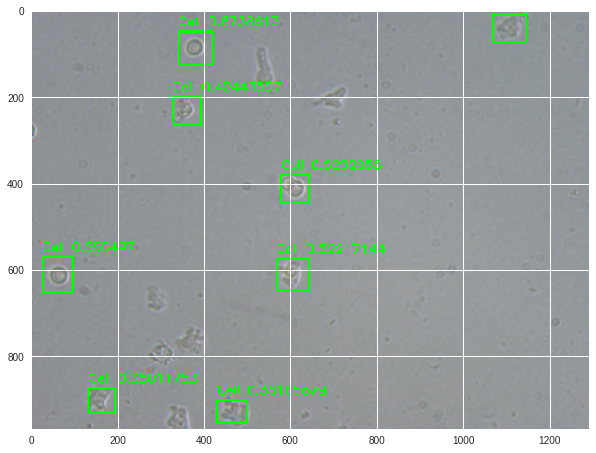

In [2]:
predict('cell.h5', './dataset/Images/Cell001.jpg')